In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting
import cmocean


/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# read in datasets

In [3]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


month_ds_dict = {} 

for month in months: 
    month_ds_dict[month] = xr.open_dataset(f'../output/{month}_300s_43200ts_ds')

# Define constants

In [4]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
times = month_ds_dict[month].time.values


# Calculate the Energy Budget

In [5]:
time = times[-2]
co2 = CO2_conc1
timestep = 300
save_freq = 288

In [6]:
energy_budget_df = pd.DataFrame(index = pd.MultiIndex(levels=[months, ['rat','ra','rt','r']],
           codes=[[0,0,0,0, 1, 1,1,1, 2, 2,2,2, 3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10, 11, 11, 11, 11], 
                  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3, 0, 1, 2, 3,]],
                                                     names = ['month','model']), 
                                columns = ['ATM_mass','TOA_rad','SFC_rad','SFC_turb','ATM_adv','ATM_heat','energy_budget'])

In [7]:
for idx_month, month in enumerate(months):
    for idx_mod, model in enumerate(['rat','ra','rt','r']):
        tmp_ds = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)
        #atmospheric mass
        energy_budget_df.loc[month, model]['ATM_mass'] = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)['heat_capacity'].sum().values #Pa
        
        #TOA Frad
        energy_budget_df.loc[month, model]['TOA_rad'] = (month_ds_dict[month].sel(model = model, 
            co2_lev = co2, time = time)['SW_flux_net_clr'][0] - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['LW_flux_net_clr'][0]).values #W/m2
        #Surface Frad
        energy_budget_df.loc[month, model]['SFC_rad'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['SW_flux_net_clr'][-1] - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['LW_flux_net_clr'][-1]).values #W/m2
        #Surface Turbulence
        energy_budget_df.loc[month, model]['SFC_turb'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['turbulent_flux'])[-1].values #W/m2
        
        #Atmospheric Advection
        energy_budget_df.loc[month, model]['ATM_adv'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['advection'][:-1].values * month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['heat_capacity']).values.sum()
        
        #Atmospheric Heating
        energy_budget_df.loc[month, model]['ATM_heat'] = ((month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = (time+save_freq*timestep))['T'].values - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = (time))['T'].values)[:-1]/(save_freq*timestep) * month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['heat_capacity']).sum().values
    
        
        energy_budget_df.loc[month, model]['energy_budget'] = (energy_budget_df.loc[month, model]['TOA_rad'] - 
                                                               energy_budget_df.loc[month, model]['SFC_rad'] +  
                                                               energy_budget_df.loc[month, model]['SFC_turb'] + 
                                                               energy_budget_df.loc[month, model]['ATM_adv'] - 
                                                               energy_budget_df.loc[month, model]['ATM_heat'])

/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


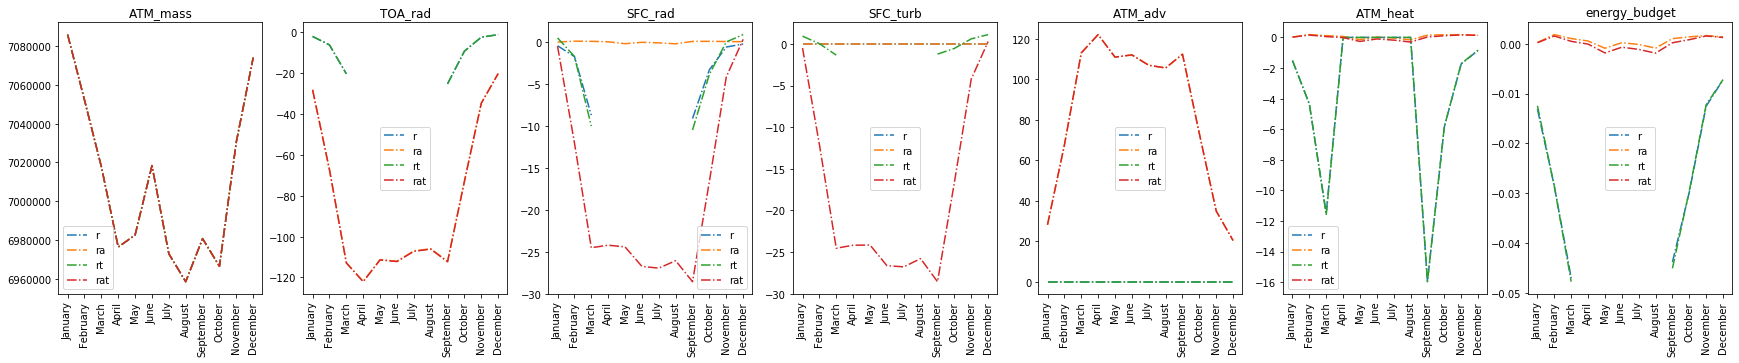

In [8]:
fig, axes = plt.subplots(1,7, figsize = (30, 5))
colors = cm.twilight(np.linspace(0,1,4))
for idx, result in enumerate(energy_budget_df.columns.values):
    ax = axes[idx]
    for model in ['r','ra','rt','rat']:
        ax.plot(energy_budget_df.query(f'model == "{model}"').index.get_level_values(0), energy_budget_df.query(f'model == "{model}"')[result], '-.', label = f'{model}')
    ax.legend()
    ax.set_xticklabels(labels = energy_budget_df.query(f'model == "{model}"').index.get_level_values(0),rotation = 90);
    ax.set_title(result)

# Temperature Structure (first timestep and final)

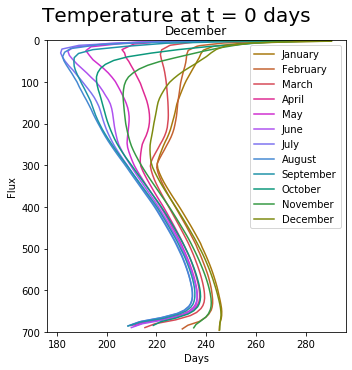

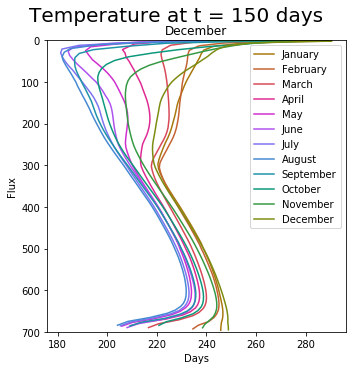

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
color = iter(cmocean.cm.phase(np.linspace(0,1,len(months)+1)))

for month in months:
    c = next(color)
    x = month_ds_dict[month].sel(model = 'rat', co2_lev = co2, time = times[0])['T']
    y =  month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['lev_full']
    ax.plot(x, y, label = month, color = c)
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_title(month)
    ax.set_ylim(700,0)
    plt.tight_layout()
plt.legend()
plt.suptitle('Temperature at t = 0 days',fontsize = 20, y = 1.02);

fig, ax = plt.subplots(figsize=(5,5))
color = iter(cmocean.cm.phase(np.linspace(0,1,len(months)+1)))

for month in months:
    c = next(color)
    x = month_ds_dict[month].sel(model = 'rat', co2_lev = co2, time = times[-1])['T']
    y =  month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['lev_full']
    ax.plot(x, y, label = month, color = c)
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_title(month)
    ax.set_ylim(700,0)
    plt.tight_layout()
plt.legend()
plt.suptitle('Temperature at t = 150 days',fontsize = 20, y = 1.02);

# ASR and OLR

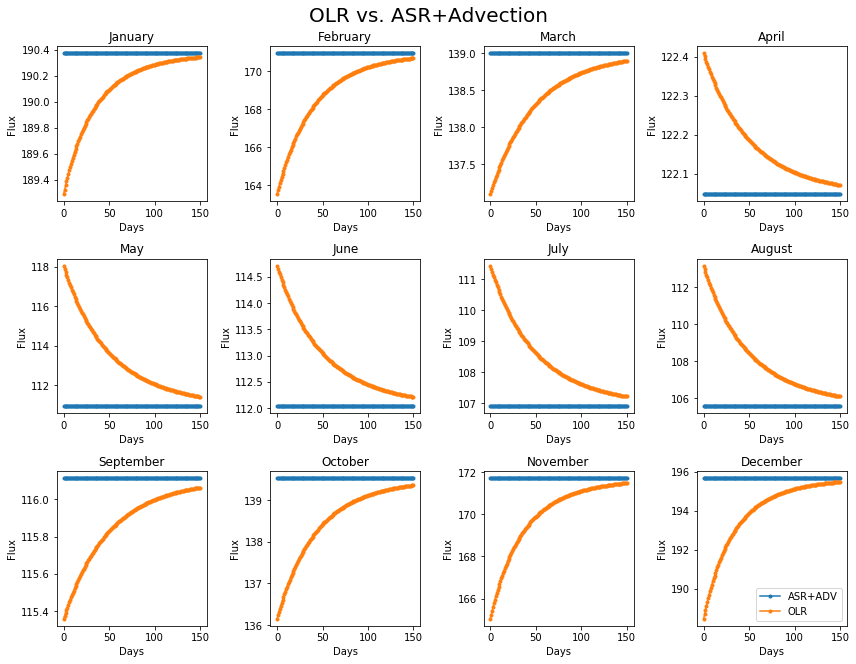

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
axes_list = [item for sublist in axes for item in sublist] 
for month in months:
    ax = axes_list.pop(0)
    y1 = month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['SW_flux_net_clr'][0]+energy_budget_df.loc[month,'rat']['ATM_adv']
    y2 = month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['LW_flux_net_clr'][0]
    x =  month_ds_dict[month].time/ climlab.constants.seconds_per_day
    ax.plot(x, y1, marker = '.', label = 'ASR+ADV')
    ax.plot(x, y2, marker = '.', label = 'OLR')
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_title(month)
    plt.tight_layout()
plt.legend()
plt.suptitle('OLR vs. ASR+Advection',fontsize = 20, y = 1.02);

# Fluxes and Heating Rates

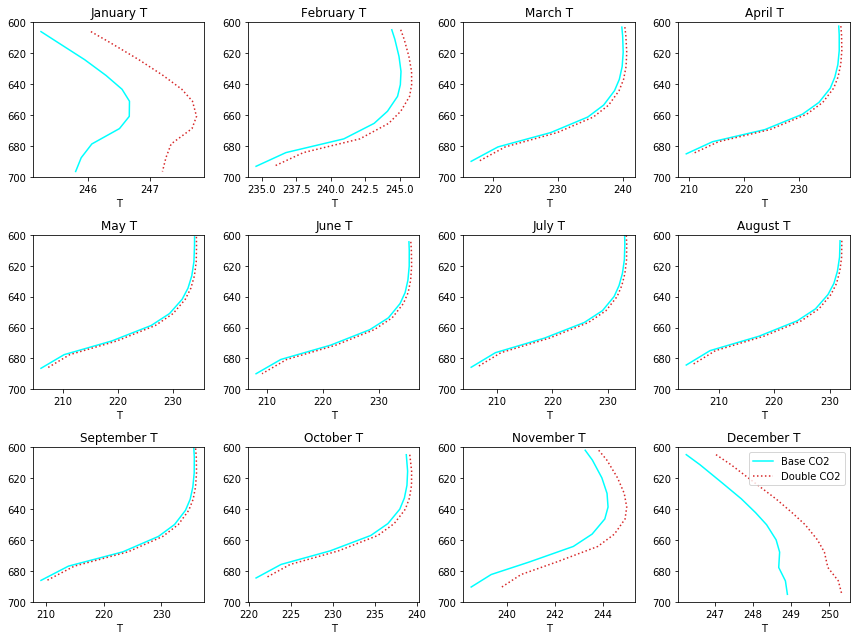

In [11]:
t = times [-1]
ylim = 600
#'advection','turb_hr', 'T', 'LW_flux_net_clr','SW_flux_net_clr'
coords_dict = {'advection':'lev_full', 'turbulent_flux':'lev_full', 'T':'lev_full', 'turb_hr':'lev_full', 'LW_flux_net_clr':'lev_bounds', 'SW_flux_net_clr':'lev_bounds'}
model = month_ds_dict
for output in ['T']:
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
    axes_list = [item for sublist in axes for item in sublist] 
    for idx, month in enumerate(months):
        ax = axes_list.pop(0)
        
        x= month_ds_dict[month].sel(co2_lev = CO2_conc1, model = 'rat', time = t)[output]
        y = month_ds_dict[month].sel(co2_lev = CO2_conc1, model = 'rat', time = t)[coords_dict[output]]
        
        yidx = y > ylim
        y = y[yidx]
        x = x[yidx]
        
        ax.plot(x,
                y, 
                color = 'cyan',
                label = 'Base CO2'
               )

        
        
        x = month_ds_dict[month].sel(co2_lev = CO2_conc2, model = 'rat', time = t)[output]
        y = month_ds_dict[month].sel(co2_lev = CO2_conc2, model = 'rat', time = t)[coords_dict[output]]
        
        yidx = y > ylim
        y = y[yidx]
        x = x[yidx]
        
        ax.plot(x,
                y, 
                color = 'C3',
                linestyle = ':',
                label = f'Double CO2'
               )
        
        ax.set_xlabel(output)
        ax.set_ylim([700,ylim])
        ax.set_title(month + ' ' + output)
        plt.tight_layout()
    plt.legend()

# Temperature Difference

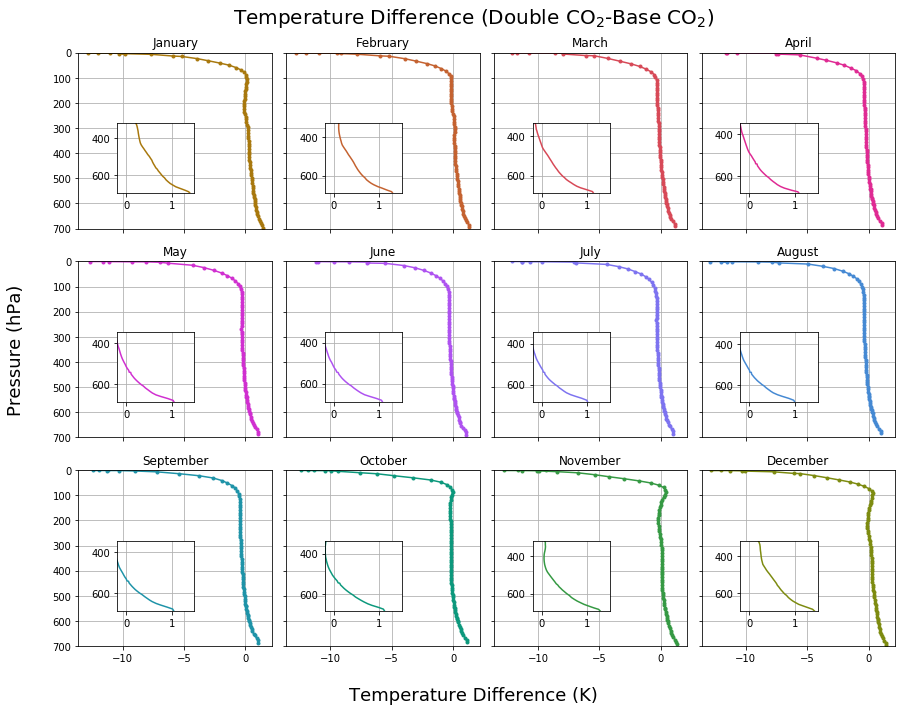

In [12]:
t = times[-1]

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

color = iter(cmocean.cm.phase(np.linspace(0,1,len(months)+1)))

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9), sharex = True, sharey = True)
axes_list = [item for sublist in axes for item in sublist] 
for month in months:
    c = next(color)
    ax = axes_list.pop(0)
    x1 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = t)['T']
    x2 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc2, time = t)['T']
    y =  month_ds_dict[month].lev_full
    ax.plot(x2-x1, y, marker = '.', label = 'Temperature', c = c)
    ax.set_title(month)
    ax.set_ylim(700,0)
    ax.grid()
    
    #inset axes
    axins = ax.inset_axes([.2,.2, .4,.4])
    axins.plot((x2-x1)[-40:], y[-40:], c = c)
    axins.set_ylim(y[-40:].max(),y[-40:].min())
    axins.set_xlim(-.2,1.5)
    axins.grid()

    
    
    plt.tight_layout()
fig.text(0.5, -0.04, 'Temperature Difference (K)', ha='center', fontsize = 18)
fig.text(-0.04, 0.5, 'Pressure (hPa)', va='center', rotation='vertical', fontsize = 18)
plt.suptitle(r'Temperature Difference (Double CO$_2$-Base CO$_2$)',fontsize = 20, y = 1.03);
plt.savefig('../figures/temp_dif.png', dpi = 150, bbox_inches = 'tight')

# Greenhouse Effect

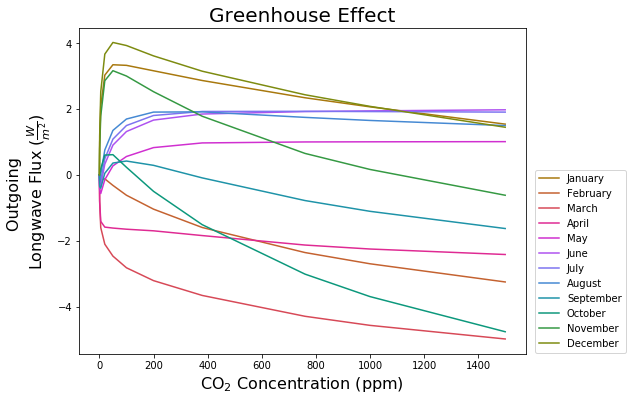

In [13]:
fig, ax = plt.subplots(figsize = (8,6))
color = iter(cmocean.cm.phase(np.linspace(0,1,len(months)+1)))

for month in months:
    x = month_ds_dict[month].co2_lev *1e6
    y = (month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])
    plt.plot(x, y,
            label = month, 
             color = next(color))
plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
plt.ylabel('Outgoing \n' r'Longwave Flux ($\frac{W}{m^2}$)', fontsize = 16)
plt.title('Greenhouse Effect', fontsize = 20)
plt.legend(bbox_to_anchor = [1.01, 0.58]);
plt.savefig('../figures/GHE.png', dpi = 150, bbox_inches = 'tight')

# Surface CO2 Effect

In [14]:
#calculate surface CO2 Effect
for month in months:
    month_ds_dict[month]['sfc_co2_effect'] = (month_ds_dict[month].sel(time = times[-1], model = 'rat').isel(lev_bounds = -1)['LW_flux_down_clr'] -
         month_ds_dict[month].sel(time = times[-1], model = 'rat', co2_lev = 0).isel(lev_bounds = -1)['LW_flux_down_clr'])

#calculate planck function and effective bandwidth    
h = 6.626E-34 #J*S
n = 667 #cm
kb = 1.38E-23 #J/k
c = 2.998E10 #cm/s
for month in months:
    #planck function
    Ta = month_ds_dict[month]['T'].sel(model = 'rat', time = 0).isel(lev_full = -1)
    month_ds_dict[month]['planck_function'] = ((2*h*c**2*n**3)/(np.exp((h*c*n)/(kb*Ta)) - 2))*1E4*np.pi
    #effective bandwidth
    month_ds_dict[month]['eff_bandwidth'] = month_ds_dict[month]['sfc_co2_effect']/month_ds_dict[month]['planck_function']
    
#effective bandwidth calculated as in Jeevanjee et al (2020, eq. 7)
l = 10.4 #cm-1
C0 = 0.25
C = month_ds_dict['January']['co2_lev'][1:].values*1e6
eff_bandwidth_est = 2*l*np.log(C/C0)

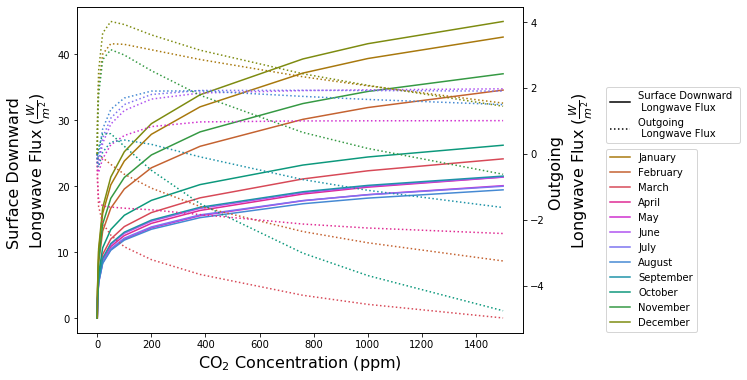

In [67]:
fig, ax1 = plt.subplots(figsize = (8,6))
color = iter(cmocean.cm.phase(np.linspace(0,1,len(months)+1)))
ax2 = ax1.twinx()
for month in months:
    c = next(color)
    #sfc longwave plot
    x = month_ds_dict[month].co2_lev *1e6
    y = month_ds_dict[month]['sfc_co2_effect']
    ax1.plot(x,y,
        label = month, 
        color = c)
    #OLR plot
    x = month_ds_dict[month].co2_lev *1e6
    y = (month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])
    ax2.plot(x, y,
            label = month, 
             color = c, 
             linestyle = ':')
    
#set up labels
ax1.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax1.set_ylabel('Surface Downward \n' r'Longwave Flux ($\frac{W}{m^2}$)', fontsize = 16)
ax2.set_ylabel('Outgoing \n' r'Longwave Flux ($\frac{W}{m^2}$)', fontsize = 16)

#set up legends
ax1.legend(bbox_to_anchor = [1.4, 0.58]);

line = Line2D([0,1],[0,1],linestyle='-', color='k')
dots = Line2D([0,1],[0,1],linestyle='dotted', color='k')

ax2.legend([line, dots],['Surface Downward \n Longwave Flux','Outgoing \n Longwave Flux'], bbox_to_anchor = [1.175, 0.77])

plt.savefig('../figures/GH_sfc_CO2_effect.png', dpi = 150, bbox_inches = 'tight')


# OLR vs Ts

In [16]:
month_plus1_ds_dict = {}

for month in months: 
    month_plus1_ds_dict[month] = xr.open_dataset(f'../output/{month}_T+1_ds')

In [69]:
for month in months: 
    #dOLR
    month_plus1_ds_dict[month]['delta_OLR'] = month_plus1_ds_dict[month]['LW_flux_net_clr'].isel(
        lev_bounds = 0).sel(
        model = 'rat', time = 0)-month_ds_dict[month]['LW_flux_net_clr'].isel(
        lev_bounds = 0).sel(
        model = 'rat', time = 0)
    #dTs
    month_plus1_ds_dict[month]['delta_Ts'] = month_plus1_ds_dict[month]['T'].isel(
        lev_full = -1).sel(
        model = 'rat', time = 0)-month_ds_dict[month]['T'].isel(
        lev_full = -1).sel(
        model = 'rat', time = 0)
    #dOLR/dTs = 4sigmaTs^3*(1-e) which is our transmisivity
    month_plus1_ds_dict[month]['emis'] = (month_plus1_ds_dict[month]['delta_OLR']/month_plus1_ds_dict[month]['delta_Ts'])
    
    #estimated dTs for our model
    month_ds_dict[month]['estimated_dTs'] = month_ds_dict[month]['sfc_co2_effect']/month_plus1_ds_dict[month]['emis']

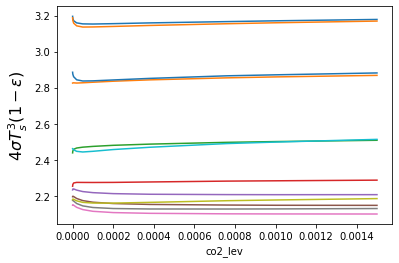

In [70]:
for month in months:
    month_plus1_ds_dict[month]['emis'].plot()
    plt.ylabel(r'$4\sigma T_s^3(1-\epsilon)$', fontsize = 16)

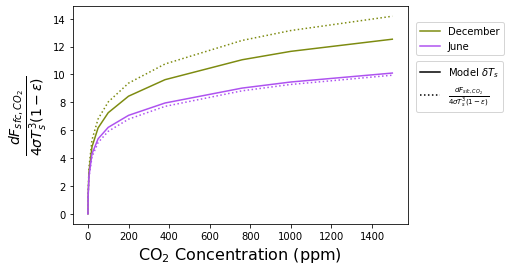

In [172]:
cmap = cmocean.cm.phase(np.linspace(0,1,len(months)+1))
colors_dict = {'December':cmap[11], 'June':cmap[5]}

fig, ax1 = plt.subplots()
plot_lines = []
for month in ['December','June']:
    c = colors_dict[month]
    y = month_ds_dict[month]['estimated_dTs']
    x = month_ds_dict[month]['co2_lev']*1e6
    plot1 = plt.plot(x, y, label = month, linestyle = ':', color = c)
    y = (month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat')- 
     month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat', co2_lev = 0))
    plot2 = plt.plot(x, y, label = month, linestyle = '-', color = c)
    plt.ylabel(r'$\frac{dF_{sfc,CO_2}}{4\sigma T_s^3(1-\epsilon)}$', fontsize = 20)
    plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
    plot_lines.append(plot2)

legend1 = plt.legend([line, dots],[r'Model $\delta T_s$',r'$\frac{dF_{sfc,CO_2}}{4\sigma T_s^3(1-\epsilon)}$'], bbox_to_anchor = [1.01, 0.77])
plt.legend([l[0] for l in plot_lines], ['December','June'], bbox_to_anchor = [1.01, 0.95])
plt.gca().add_artist(legend1)
plt.savefig('../figures/delta_Ts.png', dpi = 150, bbox_inches = 'tight')
